# Real vs. Fake Job Classification
Modules

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from google.colab import files
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
#Download 'stopwords'
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

Import original data set

In [4]:
uploaded = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


Read in uploaded data

In [5]:
Job = pd.read_csv('fake_job_postings.csv')
Job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## EDA
### Structure of Data
Shape

In [ ]:
Job.shape

(17880, 18)

NAs by feature

In [ ]:
Job.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

NAs by row

In [ ]:
NA_row = []
for i in range(len(Job.index)):
  na_temp = Job.iloc[i].isnull().sum()
  NA_row.append({'row': i+1, 'NAs': na_temp})

NA_row = pd.DataFrame(NA_row)
NA_row = NA_row.sort_values('NAs', ascending=False)
NA_row

,row,NAs
11077,11078,11
144,145,11
16627,16628,11
17756,17757,11
2315,2316,11
...,...,...
15825,15826,0
11435,11436,0
11441,11442,0
15789,15790,0


Data Types

In [ ]:
Job.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

Unique Observations

In [ ]:
Job.nunique()

job_id                 17880
title                  11231
location                3106
department              1337
salary_range             875
company_profile         1710
description            14802
requirements           11969
benefits                6206
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
fraudulent                 2
dtype: int64

Label Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Fraudulent Distribution (1 = Fraud)')

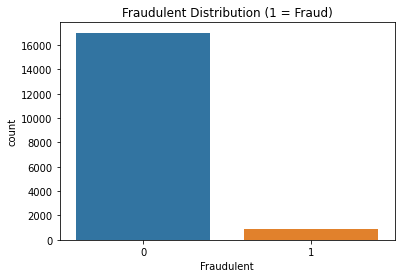

In [ ]:
labels = Job['fraudulent']


sns.countplot(labels)
plt.xlabel("Fraudulent")
plt.title("Fraudulent Distribution (1 = Fraud)")

NAs effect on fraud

Text(0.5, 0, 'Fraudulent (1 = Fraud)')

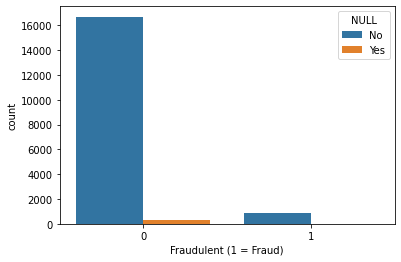

In [ ]:
Job_null = pd.DataFrame()
Job_null['NULL'] = np.where(Job['location'].isnull(), "Yes", "No")
Job_null['Fraudulent'] = Job['fraudulent']
sns.countplot(x="Fraudulent", hue="NULL", data=Job_null)
plt.xlabel("Fraudulent (1 = Fraud)")

Fill NAs with " " so our strings don't delete when combined

In [6]:
Job.fillna(" ", inplace = True)

## Creating Text Dataset


In [7]:
# Not keeping non-text variables in Job_corpus, we can add them back later
Job_corpus = pd.DataFrame()
Job_corpus['fraudulent'] = Job['fraudulent']
Job_corpus['corpus'] = Job['title'] + ' ' + Job['location'] + ' ' + Job['department'] + ' ' + Job['company_profile'] + ' ' + Job['description'] + ' ' + Job['requirements'] + ' ' + Job['benefits'] + ' ' + Job['employment_type'] + ' ' + Job['required_education'] + ' ' + Job['industry'] + ' ' + Job['function']

### Cleaning the corpus variable
Lowercase

In [8]:
Job_corpus['corpus'] = Job_corpus['corpus'].str.lower()

Remove unicode characters

In [9]:
corpus_uni = []
for ind in Job_corpus.index:
  x = Job_corpus['corpus'][ind]
  temp = x.encode('ascii', 'ignore').decode()
  corpus_uni.append(temp)

Job_corpus['corpus'] = corpus_uni


Remove Stop words

In [10]:
stop = stopwords.words("english")
corpus_stop = []
for ind in Job_corpus.index:
  x = Job_corpus['corpus'][ind]
  temp = ' '.join([word for word in x.split(' ') if word not in stop])
  corpus_stop.append(temp)

Job_corpus['corpus'] = corpus_stop

Create word cloud


In [11]:
# Split true and false fraud
Fraud = Job_corpus[(Job_corpus['fraudulent'] == 1)]
Real = Job_corpus[(Job_corpus['fraudulent'] == 0)]

# Create bag of words
Fraud_words = ''
for ind in Fraud.index:
  string = str(Fraud['corpus'][ind])
  token = string.split()
  Fraud_words += " ".join(token)+" "

Real_words = ''
for ind in Real.index:
  string = str(Real['corpus'][ind])
  token = string.split()
  Real_words += " ".join(token)+" "


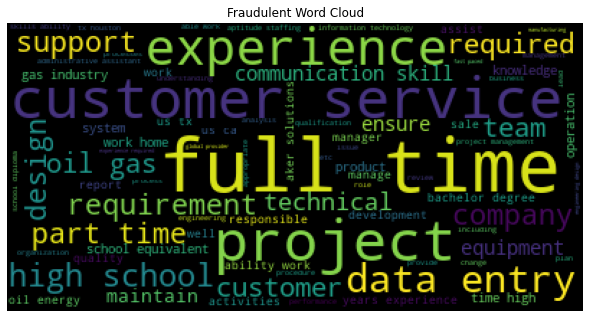

In [12]:
cloud_fraud = WordCloud().generate(Fraud_words)
plt.figure(figsize= (8,8))
plt.imshow(cloud_fraud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Fraudulent Word Cloud")
plt.show()

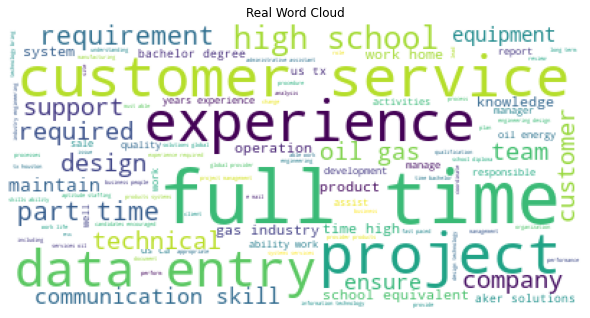

In [13]:
color_real = WordCloud(background_color='white').generate(Fraud_words)
plt.figure(figsize= (8,8))
plt.imshow(color_real)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Real Word Cloud")
plt.show()

Run Vectorizer

In [14]:
vectorizer = TfidfVectorizer()
spmat = vectorizer.fit_transform(Job_corpus['corpus'])
feat_names = vectorizer.get_feature_names()
Job_corpus = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
Job_corpus

,00,000,0000,0001pt,0005,000a,000aed,000annual,000apply,000applying,...,zurich,zus,zusammen,zusammenarbeitest,zusammenbringt,zutrifft,zweig,zylun,zyluns,zynga
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.080592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.0,0.027459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17876,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17877,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17878,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


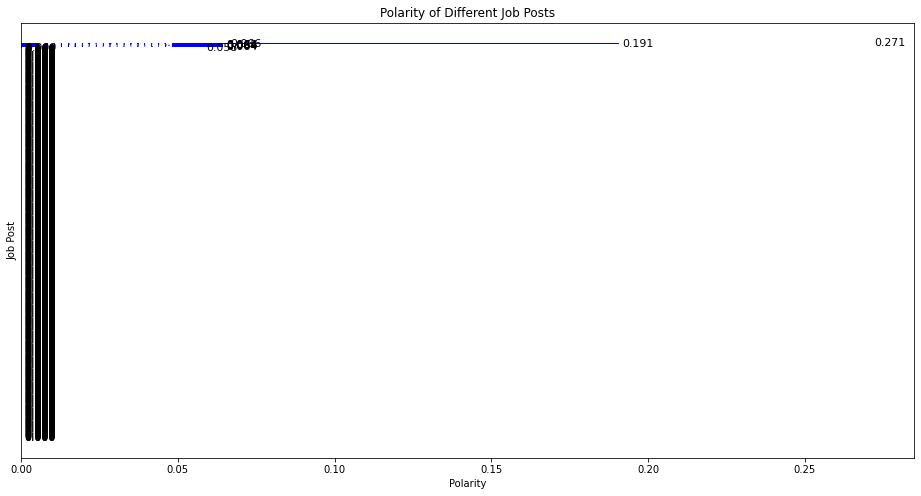

In [ ]:
product_polarity_sorted=pd.DataFrame(Job_corpus.groupby('name')['corpus'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Job Post')
plt.title('Polarity of Different Job Posts')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['corpus'],color='blue',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['corpus']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

Got this from: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

Not sure if we want to keep it...unless we can make it work...

## Create Separated Dataset

In [ ]:
text = Job[['title','location', 'company_profile', 'description', 'requirements', 'benefits']]
text.head()

,title,location,company_profile,description,requirements,benefits
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


Vectorizing each text section

In [ ]:
# vectorizing title

vectorizer = TfidfVectorizer()
spmat_title = vectorizer.fit_transform(text['title'])
feat_names = vectorizer.get_feature_names_out()
title_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_title, columns=feat_names)

In [ ]:
# vectorizing location

vectorizer = TfidfVectorizer()
spmat_location = vectorizer.fit_transform(text['location'])
feat_names = vectorizer.get_feature_names_out()
location_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_location, columns=feat_names)

In [ ]:
# vectorizing company_profile

vectorizer = TfidfVectorizer()
spmat_company = vectorizer.fit_transform(text['company_profile'])
feat_names = vectorizer.get_feature_names_out()
company_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_company, columns=feat_names)

In [ ]:
# vectorizing description

vectorizer = TfidfVectorizer()
spmat_description = vectorizer.fit_transform(text['description'])
feat_names = vectorizer.get_feature_names_out()
description_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_description, columns=feat_names)


# vectorizing requirements

vectorizer = TfidfVectorizer()
spmat_requirements = vectorizer.fit_transform(text['requirements'])
feat_names = vectorizer.get_feature_names_out()
requirements_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_requirements, columns=feat_names)

# vectorizing benefits

vectorizer = TfidfVectorizer()
spmat_benefits = vectorizer.fit_transform(text['benefits'])
feat_names = vectorizer.get_feature_names_out()
benefits_corpus = pd.DataFrame.sparse.from_spmatrix(spmat_benefits, columns=feat_names)

In [ ]:
text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]


## Creating Categorical Data set

In [ ]:
# creating cat_df
# need to import onehotencoder

from sklearn.preprocessing import OneHotEncoder
# cat variables are 

cats = Job[['employment_type', 'required_experience', 'required_education', 'function']]

# converting using one hot encoder

ohe = OneHotEncoder(drop = 'first', 
                    sparse = False).fit(cats) # dropping first column of each feature to not reduce redudancy
cat_data = ohe.transform(cats)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names_out(['employment_type',  'required_experience', 'required_education', 'function'])) 
cat_df.head()

,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,employment_type_nan,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,...,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing,function_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

## Perceptrons


### Perceptron with text section data

In [ ]:
text_fts = [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

text_ft_accuracy = []

for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, labels, test_size = 0.80, random_state=42)
  model = Perceptron(max_iter=3).fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  train_acc = accuracy_score(y_train, y_pred_train)
  test_acc = accuracy_score(y_test, y_pred_test)
  text_ft_accuracy.append({'training accuracy': train_acc, 'testing accuracy': test_acc})

In [ ]:
text_ft_accuracy

In [ ]:
# running this again, but with top 10, 25, and 50 features
from sklearn.feature_selection import SelectKBest, chi2

k_vals = [10, 25, 50]
text_topft_accuracy = []
for i  in text_fts:
  X_train, X_test, y_train, y_test = train_test_split(i, labels, test_size = 0.80, random_state=42)
  for k in k_vals:
    pipe = make_pipeline(SelectKBest(chi2, k = k), Perceptron(class_weight = 'balanced'))
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    cols = pipe[0].get_support(indices = True)
    new_X_features = X_train.iloc[:, cols]
    print('X_new has', k ,'best features: %s' % list(new_X_features.columns.values.tolist()))

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    text_topft_accuracy.append({'Top k features': k, 'Training Accuracy': train_acc, 'Test Accuracy': test_acc})


Order of features: [title_corpus, location_corpus, company_corpus, description_corpus, requirements_corpus, benefits_corpus]

In [ ]:
pd.DataFrame(text_topft_accuracy)

,Top k features,Training Accuracy,Test Accuracy
0,10,0.049776,0.048098
1,25,0.052852,0.051174
2,50,0.059004,0.056348
3,10,0.049497,0.048238
4,25,0.914150,0.905271
5,50,0.929251,0.911284
6,10,0.049776,0.048098
7,25,0.053412,0.051314
8,50,0.053412,0.051804
9,10,0.049776,0.048098


Each text feature seemed to have very accurate results with the data, but only ones like location and benefits had accurate results with limited/most important features

**longer way below, not looped**
first, title_corpus

X_train, X_test, y_train, y_test = train_test_split(title_corpus, labels, test_size = 0.80, random_state=42)
title_model = Perceptron(max_iter=1).fit(X_train, y_train)

title_pred = title_model.predict(X_test)

accuracy = accuracy_score(title_pred, y_test)

text_ft_accuracy = []
text_ft_accuracy.append({'Title': accuracy})

### Perceptron with Categorical Data

In [ ]:
# using these categorical variables to predict 

X_train, X_test, y_train, y_test = train_test_split(cat_df, labels, test_size = 0.80, random_state=42)

from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy = 'most_frequent') # imputing categorical features with mode
balanced_model = make_pipeline(mode_imputer, Perceptron(class_weight='balanced', random_state = 42))

balanced_model.fit(X_train, y_train)


# make predictions on training set
y_pred_b = balanced_model.predict(X_train)

# make predictions on test set
y_pred_test_b = balanced_model.predict(X_test)

# print the results 
print("Balanced Accuracy:"); print("="*len("Accuracy:"))
print(f"Balanced TRAIN: {accuracy_score(y_train, y_pred_b)}")
print(f"Balanced TEST: {accuracy_score(y_test, y_pred_test_b)}")

Balanced Accuracy:
Balanced TRAIN: 0.805648769574944
Balanced TEST: 0.7957214765100671


## Random Forest

### Random Forest with corpus data
Split data set

In [63]:
y = Job['fraudulent']
labenc = LabelEncoder()
y = labenc.fit_transform(y)

X = Job_corpus.drop(columns = ['fraudulent'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state=42)

Create Tuning Grid - Taking forever on colab server, working on doing this locally. 

In [69]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 10, stop=210, num = 21)]
max_depth.append(None)
min_samples_split = [2,5,10,20]
min_samples_leaf = [1,2,4,8]
bootstrap = [True, False]

tr_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}
print(tr_grid)

forest = RandomForestClassifier()

forest_tuned = RandomizedSearchCV(estimator = forest, param_distributions=tr_grid,
                                  n_iter = 5, cv = 5, random_state = 42, n_jobs = 2)
forest_tuned.fit(X_train, y_train)
forest_tuned.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False]}


{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

Create base model

In [64]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

Metrics

In [68]:
print("Accuracy: ", accuracy_score(y_test, y_pred),
      "\nF1 Score:", f1_score(y_test, y_pred),
      )

Accuracy:  0.9717561521252797 
F1 Score: 0.5843621399176955


In [62]:
test = Job['fraudulent']
np.unique(test)

array([0, 1])